In [21]:
from h3 import h3
import folium

def visualize_hexagons(hexagons, color="red", folium_map=None):
    """
    hexagons is a list of hexcluster. Each hexcluster is a list of hexagons. 
    eg. [[hex1, hex2], [hex3, hex4]]
    """
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=10, tiles='cartodbpositron')
    else:
        m = folium_map
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
        m.add_child(my_PolyLine)
    return m

In [11]:
import csv
from datetime import datetime

data = []

with open('data/41467_2020_17591_MOESM6_ESM.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            try:
                data.append({
                    'time': datetime.strptime(row[1], '%Y-%m-%d %H:%M:%S.%f'),
                    'latitude': float(row[2]),
                    'longitude': float(row[3]),
                    'magnitudes': float(row[9])
                })
            except Exception:
                print(row)
            line_count += 1
    print(f'Processed {line_count} lines.')

Column names are , origin_time, latitude, longitude, depth, EX, EY, EZ, evid, magnitudes
['918', '2000-10-07 11:44:20.930', '35.34683', '133.287476', '14.92', '2.4', '3.6', '8.6', '202440', '']
['1996', '2000-10-08 16:49:21.390', '35.271883', '133.360433', '18.82', '1.2', '1.9', '3.6', '205299', '']
['2006', '2000-10-08 17:04:21.640', '35.248242', '133.37478', '13.54', '1.0', '1.8', '2.7', '205327', '']
['2518', '2000-10-09 06:58:21.490', '35.278849', '133.345483', '7.97', '1.7', '2.4', '4.9', '206773', '']
['2988', '2000-10-09 19:44:20.240', '35.301326', '133.311735', '17.93', '2.2', '3.5', '4.5', '207967', '']
['3144', '2000-10-10 00:03:22.250', '35.331763', '133.292008', '9.38', '1.1', '1.2', '1.7', '208365', '']
['3254', '2000-10-10 02:50:29.370', '35.171667', '133.138127', '5.08', '1.6', '1.7', '5.8', '208619', '']
['3837', '2000-10-10 22:53:21.680', '35.280859', '133.335856', '16.48', '0.6', '1.0', '2.0', '210320', '']
['4502', '2000-10-11 20:50:20.680', '35.31322', '133.300277',

In [135]:
RESOLUTION = 5

for r in data:
    r['h3'] = h3.geo_to_h3(r['latitude'], r['longitude'], RESOLUTION)

In [136]:
h3_address = set([r['h3'] for r in data])
m = visualize_hexagons(h3_address)
display(m)

In [139]:
TEMPLATE = '{}-{}-{}'
def identifier(record):
    time = record['time']
    return TEMPLATE.format(time.year, time.month, time.day)

In [140]:
import numpy as np

columns = {}
index = 0
for h in h3_address:
    columns[h] = index
    index += 1

datamap = {}
for r in data:
    key = identifier(r)
    if key not in datamap:
        datamap[key] = [0 for _ in range(len(h3_address))]
    datamap[key][columns[r['h3']]] += r['magnitudes']

matrix = np.array([np.array(datamap[key]) for key in datamap.keys()])

In [141]:
len(matrix)

41

In [150]:
import pysindy as ps

dt = 0.001

model = ps.SINDy()
model.fit(matrix, t=dt)
model.print()

x0' = 1.023 1 + -2.848 x0 + -10.890 x1 + 45.208 x2 + 2.179 x3 + 3.339 x4 + -0.318 x5 + 0.229 x7 + 0.390 x8 + -24.729 x10 + 0.182 x11 + 0.738 x13 + 21.400 x14 + -39.358 x15 + -18.161 x0^2 + -30.456 x0 x1 + 14.430 x0 x2 + -28.519 x0 x3 + 41.191 x0 x4 + 4.244 x0 x5 + -31.281 x0 x6 + 34.299 x0 x7 + -60.148 x0 x8 + 1.527 x0 x9 + 53.085 x0 x10 + 1.043 x0 x11 + 0.282 x0 x12 + -57.881 x0 x13 + -79.770 x0 x14 + -19.411 x0 x15 + -11.485 x1^2 + -1.261 x1 x2 + 52.385 x1 x3 + 3.541 x1 x4 + 3.425 x1 x5 + -5.696 x1 x6 + -11.571 x1 x7 + -41.035 x1 x8 + -21.021 x1 x9 + -14.656 x1 x10 + 13.683 x1 x11 + 2.211 x1 x12 + 42.744 x1 x13 + 84.373 x1 x14 + 6.891 x1 x15 + 0.517 x2^2 + 21.712 x2 x3 + -27.777 x2 x4 + -12.412 x2 x5 + 61.447 x2 x6 + -6.442 x2 x7 + 48.335 x2 x8 + 24.913 x2 x9 + 67.050 x2 x11 + 8.690 x2 x12 + 36.239 x2 x13 + 6.050 x2 x14 + -3.655 x2 x15 + 11.247 x3^2 + 8.442 x3 x4 + 0.320 x3 x5 + 4.999 x3 x6 + 18.782 x3 x7 + 2.515 x3 x8 + -18.407 x3 x10 + 0.899 x3 x11 + -2.086 x3 x13 + 88.561 x3 x14 +

In [146]:
import math 
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [191]:
def library_parser(data):
    features = model.feature_library.get_feature_names()
    n = len(data)
    m = len(features)
    
    result = [None] * m
    for i in range(0, m):
        r = 1
        for elm in features[i].split(' '):
            var_index = None
            power = 1
            if 'x' in elm:
                elm = elm.replace('x', '')
                if '^' in elm:
                    var_index = int(elm.split('^')[0])
                    power = int(elm.split('^')[1])
                else:
                    var_index = int(elm)
                r = r * pow(data[var_index], power) 
        result[i] = r
    return result


def find_steady_state(X):
    prev_state = X[0]
    for i in range(1,len(X)):
        state = X[i]
        diff = np.subtract(state, prev_state)
        prev_state = state
        if -0.0001 < max(np.amax(diff), np.amin(diff), key=abs) < 0.0001:
            return state
        
def sindy(data, t):
    coefficients = model.coefficients()
    cf = library_parser(data)
    result = np.empty(len(data))
    for index in range(0, len(data)):
        sum = 0
        for i in range(0, len(cf)):
            sum += coefficients[index][i] * cf[i]
        result[index] = sum
    return result


def apply_perturbation(alpha, perturbed_node, steady_state, dynamic_func):
    perturbation = np.zeros(number_of_nodes)
    perturbation[perturbed_node] = (steady_state[perturbed_node] if steady_state[perturbed_node] > 0 else 1) * alpha
    perturbed = np.add(steady_state, perturbation)

    t_perturbed = np.arange(0, 100, dt)
    x_perturbed = odeint(dynamic_func, perturbed, t_perturbed)
    return x_perturbed

def flow(X, ignore=0):
    prev_state = X[0]
    result = [prev_state]
    for i in range(1,len(X)):
        state = X[i]
        diff = np.subtract(state, prev_state)
        if i > ignore and i < 120:
            result = np.vstack((result, state))
        prev_state = state
        if -0.0001 < max(np.amax(diff), np.amin(diff), key=abs) < 0.0100:
            return result
    print('chaos state')
    return result

def plot_flow(flow):
    fpr = 2
    plt.rcParams["figure.figsize"] = (16, 9)

    plt.figure(1)
    fig, axs = plt.subplots(int(number_of_nodes/fpr), fpr)
    for i in range(0,number_of_nodes):
        axsi = axs[int(i/fpr), i%fpr]
        axsi.plot(flow[:,i])
        axsi.set_title('x'+str(i))
    plt.show()

    
def calculate_g(alpha, steady_state, dynamic_func):
    g_matrix = np.empty((number_of_nodes,number_of_nodes))
    t_perturbed = np.arange(0, 10, dt)
    
    for i in range(0, number_of_nodes):
        perturbation_i = np.zeros(number_of_nodes)
        perturbation_i[i] = steady_state[i] * alpha
        perturbed_i = np.add(steady_state, perturbation_i[i])

        x_perturbed_i = odeint(dynamic_func, perturbed_i, t_perturbed)
        final_state_i = x_perturbed_i[-1]
        diff_i = np.subtract(final_state_i, steady_state)

        dxi_xi = diff_i[i]/steady_state[i]
        for j in range(0, number_of_nodes):
            dxj_xj = diff_i[j]/steady_state[j]
            g_matrix[i,j] = abs(dxi_xi/dxj_xj)
    
    return g_matrix

def find_g_dist(g_matrix):
    g_dist = []
    for row in g_matrix:
        for gij in row:
            g_dist.append(gij)
    return g_dist

def calculate_f(g_matrix):
    f = np.zeros(number_of_nodes)
    logf = np.zeros(number_of_nodes)
    for i in range(0, number_of_nodes):
        f_i = np.zeros(number_of_nodes)
        for n in range(0, number_of_nodes):
            sum_gmn = 0
            for m in range(0, number_of_nodes):
                sum_gmn += g_matrix[m,n]
            sum_gmi = 0
            for m in range(0, number_of_nodes):
                if i==m:
                    continue
                sum_gmi += g_matrix[m,i]/sum_gmn
            f_i[n] = g_matrix[i,n] * sum_gmi

        for n in range(0, number_of_nodes):
            if i==n:
                continue
            f[i] += f_i[n]
        f[i] /= (number_of_nodes-1)
        logf[i] = math.log(f[i], graph.degree[i])
    
    return f, logf

In [152]:
number_of_nodes = len(matrix[0])

t_test = np.arange(0, 100, dt)
x0_test = np.random.rand(number_of_nodes)
x_test = odeint(sindy, x0_test, t_test)
steady_state = find_steady_state(x_test)
print('steady_state:', steady_state)

steady_state: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [178]:
alpha = 2
perturbed_node = 8
x_perturbed = apply_perturbation(alpha, perturbed_node, steady_state, sindy)
perturbed_steady_state = find_steady_state(x_perturbed)
print('perturbed_steady_state:', perturbed_steady_state)

perturbed_steady_state: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


<Figure size 1152x648 with 0 Axes>

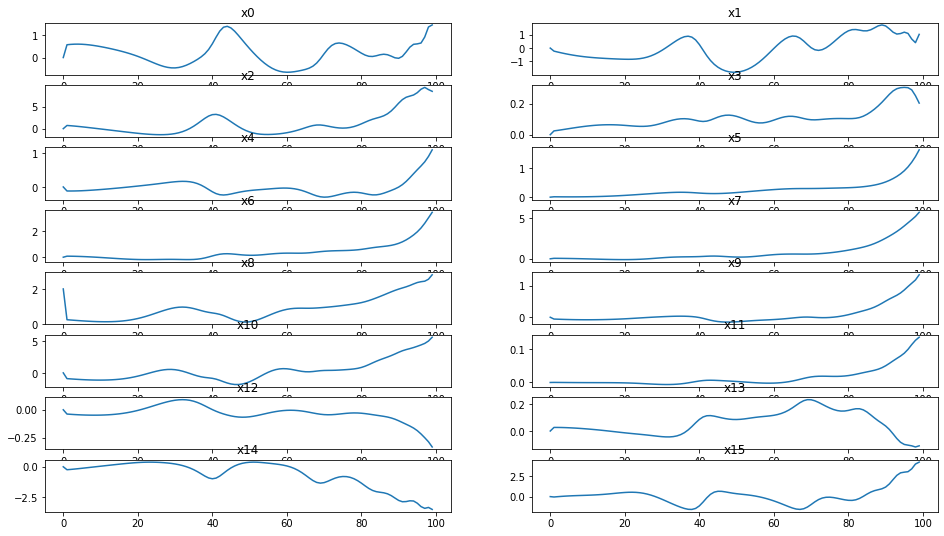

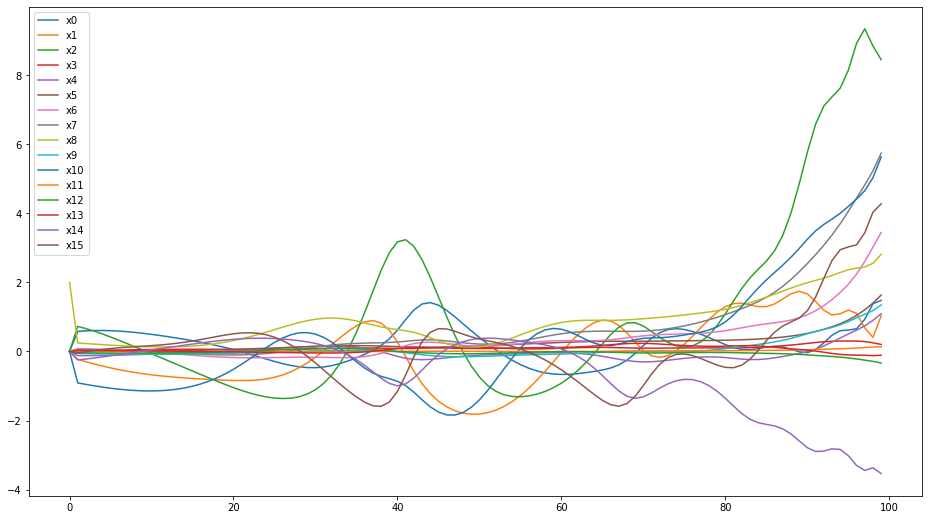

In [192]:
x_flow = flow(x_perturbed, 20)

plot_flow(x_flow)

plt.rcParams["figure.figsize"] = (16, 9)
plt.figure(3)
for i in range(0,number_of_nodes):
    plt.plot(x_flow[:,i], label='x'+str(i))
plt.legend()
plt.show()

In [188]:
g_matrix = calculate_g(alpha, steady_state, sindy)
g_dist = find_g_dist(g_matrix)

/home/ali/.local/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/ali/.local/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in double_scalars
/home/ali/.local/lib/python3.6/site-packages/ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in double_scalars
/home/ali/.local/lib/python3.6/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in double_scalars


KeyboardInterrupt: 

/home/ali/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6620: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/ali/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6621: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

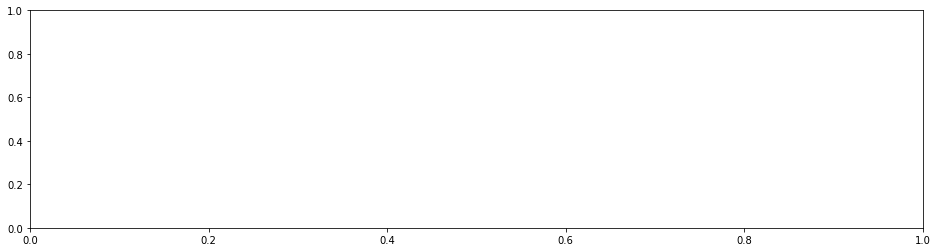

In [131]:
plt.rcParams["figure.figsize"] = (16, 4)
plt.figure(2)
plt.hist(g_dist)
plt.show()

In [132]:
f, logf = calculate_f(g_matrix)
print(f)
print(logf)

NameError: name 'graph' is not defined